### Importing Necessary Libraries

In [1]:
import json,shutil, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob; from PIL import ImageFile
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

C:\Users\Nodir\anaconda3\envs\segmentation\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Custom Dataset

In [2]:
data_path = r"D:\AI\Datasets_DL\Dental_Xray_Semantic_Segmentation\Dental_X_Ray_Images"
ImageFile.LOAD_TRUNCATED_IMAGES = True
class CustomDataset(Dataset):
    def __init__(self, data_path, transformations = None):
       
        self.transformations = transformations
        self.num_classes = 2
        
        self.img_pathes = sorted(glob(f"{data_path}/images/*.png"))
        self.img_labels = sorted(glob(f"{data_path}/masks/*.png"))
        self.img_labels = [fname.replace("images", "masks") for fname in self.img_pathes if os.path.isfile(fname.replace("images", "masks"))]
        assert len(self.img_pathes) == len(self.img_labels)
    def __len__(self): return len(self.img_pathes)

    def __getitem__(self, idx):
        img, label = self.get_img_label(self.img_pathes[idx], self.img_labels[idx])
        if self.transformations: img, label = self.apply_transformations(img, label)
        return img, (label/255).int()

    def get_img_label(self, img_path, label_path):
        return self.read_img(img_path, label_path)

    def read_img(self, img_path, label_path):
        return np.array(Image.open(img_path).convert("RGB")), np.array(Image.open(label_path).convert("L"))

    def apply_transformations(self, img, label):
        transformed = self.transformations(image = img, mask = label)
        return transformed["image"], transformed["mask"]


def get_dataloader(dataset, bs, transformations, split = [0.9, 0.05]):
    ds = CustomDataset(data_path = data_path, transformations = transformations)
    num_classes = ds.num_classes

    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)
    tr_ds, vl_ds, ts_ds = random_split(ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True)
    vl_dl = DataLoader(vl_ds, batch_size = bs, shuffle = False)
    ts_dl = DataLoader(ts_ds, batch_size = 1, shuffle = False)
    return tr_dl, vl_dl, ts_dl, num_classes

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
img_size = 256
tfs = A.Compose([ A.Resize(img_size, img_size), A.augmentations.transforms.Normalize(mean=mean, std=std), A.ToTensorV2(transpose_mask = True)], is_check_shapes = False)
ds = CustomDataset(data_path = data_path, transformations = tfs)
tr_dl, vl_dl, ts_dl, num_classes = get_dataloader(dataset = data_path, bs = 5, transformations = tfs)
# ds = CustomDataset(data_path = data_path, transformations = tfs)

print(len(ds))
print(f"{len(tr_dl)}")
print(f"{len(vl_dl)}")
print(f"{len(ts_dl)}")

64
12
1
4


### Visualization

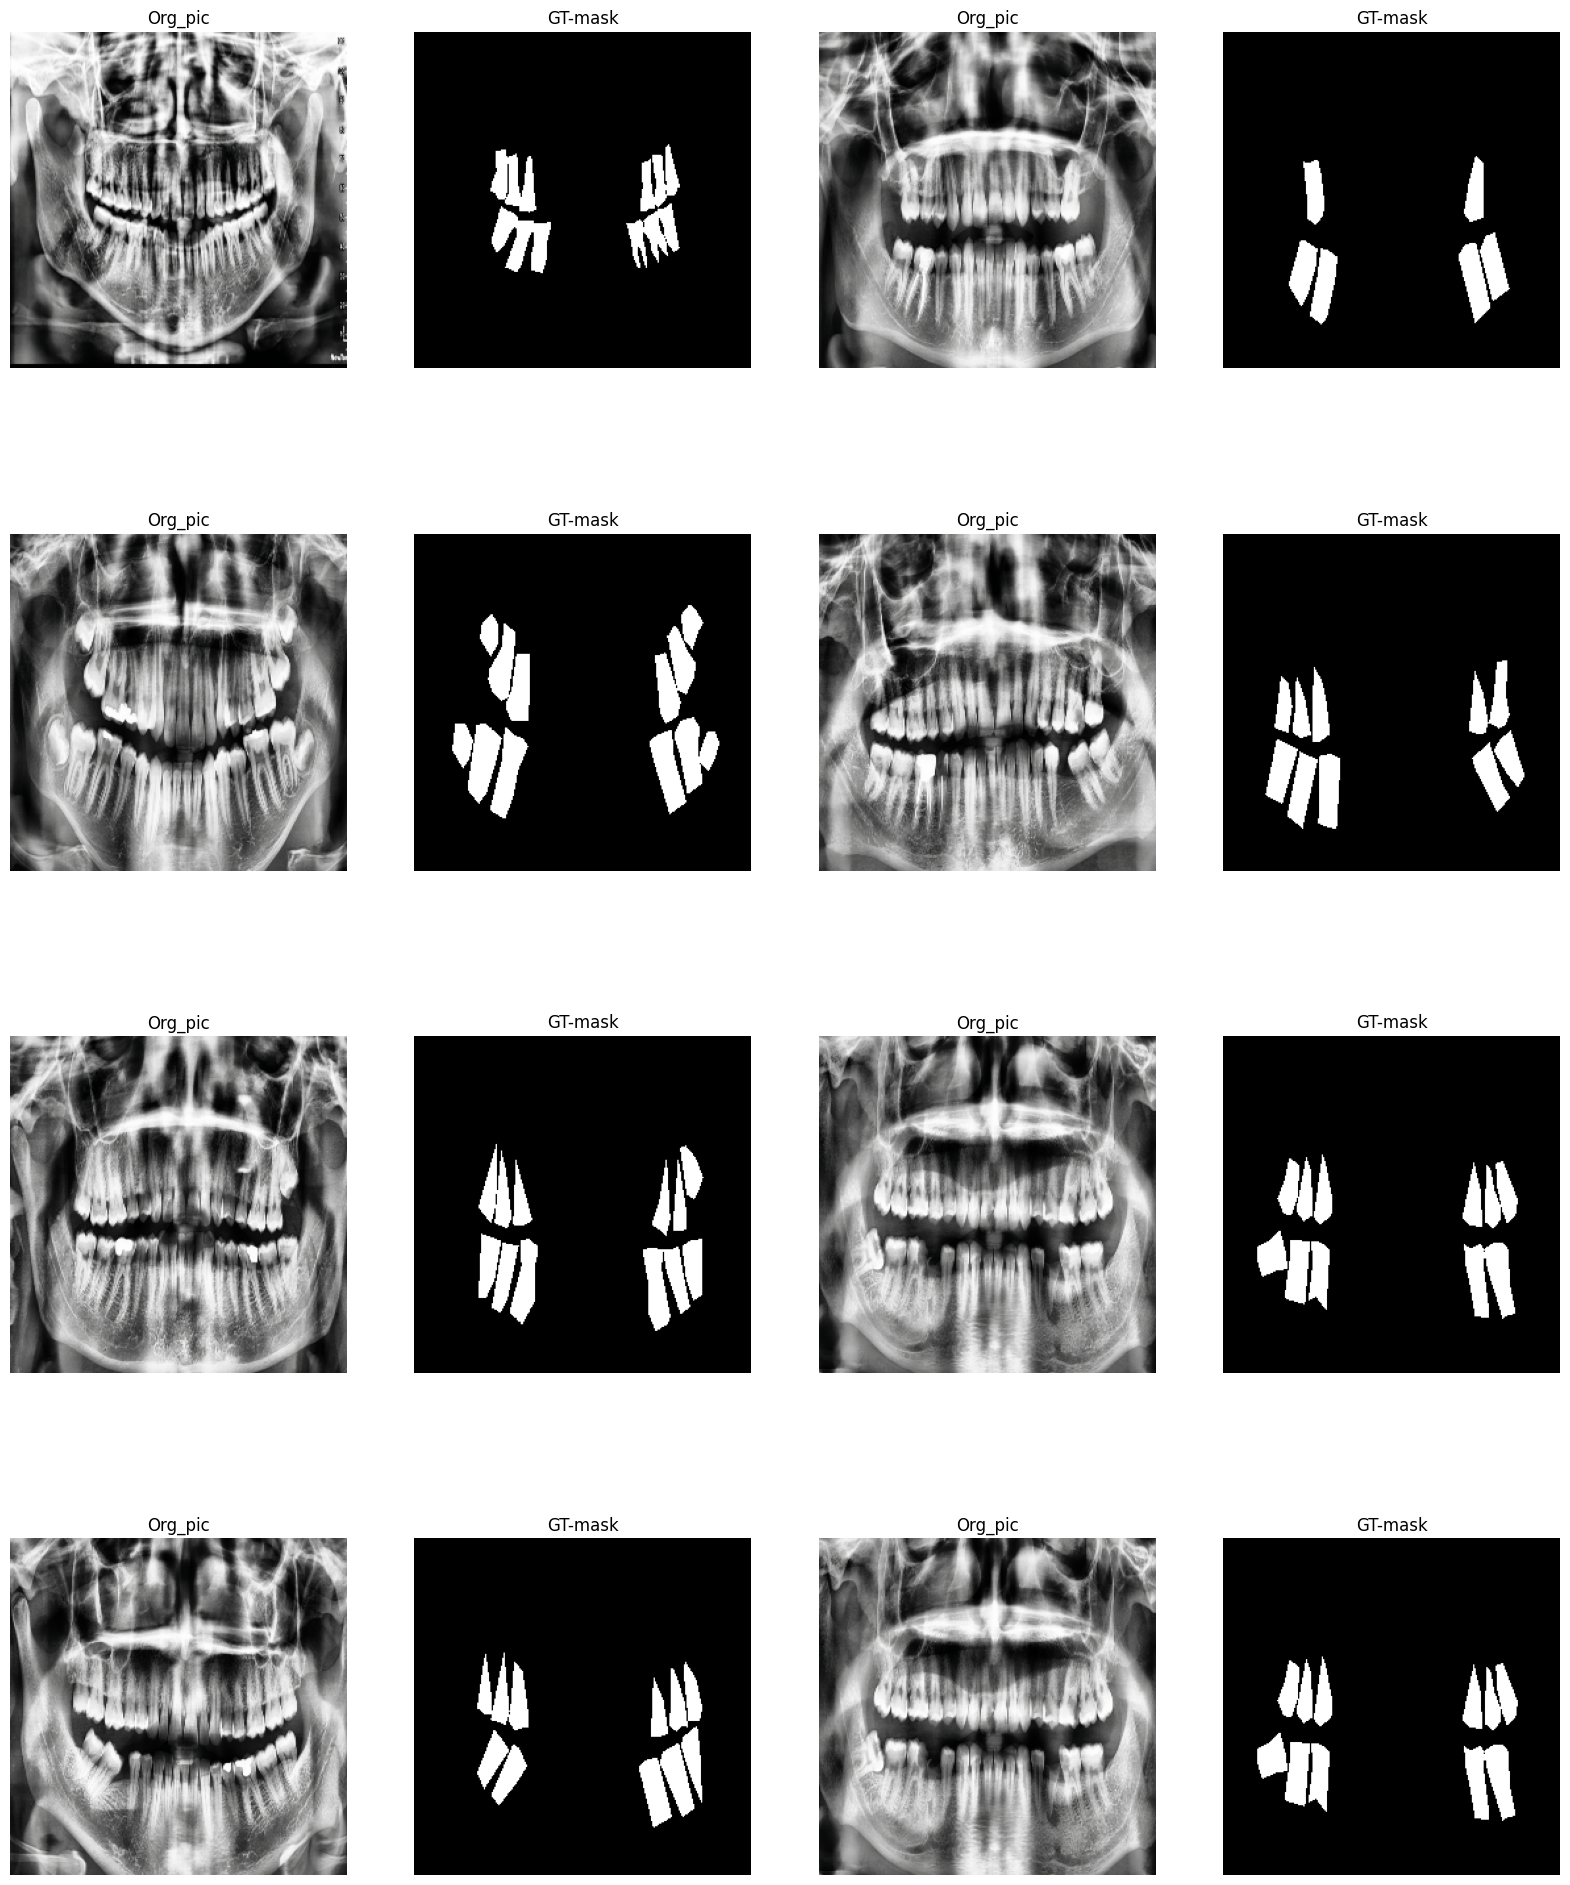

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as tfs
class DataVisualize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        self.inv_transform = self._get_inverse_transform()

    def _get_inverse_transform(self):
        """Create an inverse transformation to revert normalization."""
        return tfs.Compose([
            tfs.Normalize(mean=[0., 0., 0.], std=[1 / s for s in self.std]),
            tfs.Normalize(mean=[-m for m in self.mean], std=[1., 1., 1.])
        ])

    def tensor_2_np(self, tensor):
        is_rgb = len(tensor) == 3
        if is_rgb:
            tensor = self.inv_transform(tensor)
            np_array = (tensor*255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)
        else:
            np_array = (tensor * 255).detach().cpu().numpy().astype(np.uint8)

        
        # print("Mask unique values:", np.unique(np_array)) 
        return np_array

    def _plot(self, rows, cols, count, img, is_gt = False, title = "Org_pic"):
        plt.subplot(rows, cols, count)
        plt.imshow(self.tensor_2_np(img.squeeze(0).float()) if is_gt else self.tensor_2_np(img.squeeze(0)), cmap = "gray")
        
        plt.axis("off")
        plt.title(title)
        
        return count + 1

    def visualize_final(self, dataset, num_images):
        plt.figure(figsize = (20,25))
        rows = num_images // 4
        cols = num_images // rows

        count = 1
        indices = [random.randint(0, len(dataset) - 1) for _ in range(num_images)]
        
        for index in indices:
            if count > num_images:
                break
        
            img, mask = dataset[index]
            count = self._plot(rows, cols, count, img)
             

            count = self._plot(rows, cols, count, mask, is_gt = True, title = "GT-mask")
        plt.show()
        
visualizer = DataVisualize(mean=mean, std=std)
visualizer.visualize_final(dataset = tr_dl.dataset, num_images = 16)

In [ ]:
### Training

In [7]:
import segmentation_models_pytorch as smp, time
from torch.nn import functional as F
from tqdm import tqdm

model = smp.DeepLabV3Plus(classes = num_classes)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics:
    def __init__(self, pred, label, loss_fn, eps = 1e-10, n_cls = 2):
        self.pred = torch.argmax(pred, dim = 1)
        self.label = label.squeeze(1)
        self.pred_ = pred
        self.loss_fn = loss_fn
        self.eps = eps
        self.n_cls = n_cls

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PixelAcc(self):
        with torch.no_grad():
            
            match = torch.eq(self.pred, self.label).int()
            
        return float(match.sum())/ float(match.numel())

    def meanIoU(self):
        with torch.no_grad():
            
            pred = self.to_contiguous(self.pred)
            label = self.to_contiguous(self.label)
            iou_per_class = []

            for c in range(num_classes):
                match_pred = pred == c
                match_label = label == c

                if match_label.long().sum().int() == 0:
                    iou_per_class.append(np.nan)
                else:
                    intersect = torch.logical_and(match_pred, match_label).sum().float().item()
                    union = torch.logical_or(match_pred, match_label).sum().float().item()
                    iou = intersect / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)
    def loss(self):
        return self.loss_fn(self.pred_, self.label.long())
        

                        

In [9]:
class Trainer:
    def __init__(self, model, tr_dl, vl_dl, loss_fn, optimizer, device, n_cls, folder_2_save = "segmentation Best models"):
        self.model = model
        self.tr_dl = tr_dl
        self.vl_dl = vl_dl
        self.device = device
        self.n_cls = n_cls
        self.folder_2_save = folder_2_save
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        os.makedirs(self.folder_2_save, exist_ok = True)

    def run(self, epochs, path_prefix):

        self.model.to(self.device)
        tr_loss, tr_pa, tr_iou = [], [], []
        vl_loss, vl_pa, vl_iou = [], [], []
        best_loss, not_improved = np.inf, 0

        print(f"Training process is beginning...")
        for epoch in range(1, epochs+1):
            print(f"{epoch}/{epochs}")
            
            # Train process
            self.model.train()
            tr_metrics = self.process_epoch(self.tr_dl, is_training = True)

            # Validation 
            self.model.eval()
            with torch.no_grad():
                vl_metrics = self.process_epoch(self.vl_dl, is_training = False)

            tr_loss.append(tr_metrics["loss"])
            tr_pa.append(tr_metrics["pa"])
            tr_iou.append(tr_metrics["iou"])
            vl_loss.append(vl_metrics["loss"])
            vl_pa.append(vl_metrics["pa"])
            vl_iou.append(vl_metrics["iou"])

            print(f"Train Loss: {tr_metrics['loss']:.3f} | Train PA: {tr_metrics['pa']:.3f} | Train IoU: {tr_metrics['iou']:.3f}")
            print(f"Valid loss {vl_metrics['loss']:.3f} | Valid PA {vl_metrics['pa']:.3f} | Valid IOU {vl_metrics['iou']:.3f}")
            
            if best_loss > vl_metrics["loss"]:
                best_loss = vl_metrics["loss"]
                not_improved = 0
                torch.save(self.model, f"{self.folder_2_save}/{path_prefix}dental_best_model.pth")
            else:
                not_improved += 1
                if not_improved == 7:
                    print(f"Early stopping triggered. Best loss is - {best_loss}")
                    break

        return {
            "tr_loss" : tr_loss, "tr_pa" : tr_pa, "tr_iou" : tr_iou,
            "vl_loss" : vl_loss, "vl_pa" : vl_pa, "vl_iou" : vl_iou,
            
        }

    def process_epoch(self, dataloader, is_training):
        if is_training:
            phase = "Train"
        else:
            phase = "Validation"
        total_loss, total_pa, total_iou = 0, 0, 0
        for img, label in tqdm(dataloader, desc = f"{phase} process..."):
            img = img.to(self.device)
            label = label.to(self.device)
            if is_training:
                pred = self.model(img)
                metrics = Metrics(pred, label, self.loss_fn, n_cls = self.n_cls)
                loss = metrics.loss()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            else: # Validation
                with torch.no_grad():
                    pred = self.model(img)
                    metrics = Metrics(pred, label, self.loss_fn, n_cls = self.n_cls)
                    loss = metrics.loss()

            total_loss += loss.item()
            total_pa   += metrics.PixelAcc()
            total_iou  += metrics.meanIoU()
        num_batches = len(dataloader)
        return {
            "loss" : total_loss / num_batches,
            "pa"   : total_pa / num_batches,
            "iou"  : total_iou / num_batches,
        }

device = "cuda" if torch.cuda.is_available() else "cpu"

trainer = Trainer(model = model, tr_dl = tr_dl, vl_dl = vl_dl, loss_fn = loss_fn, optimizer = optimizer, device = device, n_cls = num_classes)
final = trainer.run(epochs = 30, path_prefix = "dental")
                
            

Training process is beginning...
1/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Train Loss: 0.698 | Train PA: 0.572 | Train IoU: 0.361
Valid loss 0.731 | Valid PA 0.102 | Valid IOU 0.053
2/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Train Loss: 0.364 | Train PA: 0.923 | Train IoU: 0.708
Valid loss 0.609 | Valid PA 0.862 | Valid IOU 0.613
3/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


Train Loss: 0.212 | Train PA: 0.958 | Train IoU: 0.780
Valid loss 0.341 | Valid PA 0.935 | Valid IOU 0.743
4/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.77it/s]


Train Loss: 0.149 | Train PA: 0.965 | Train IoU: 0.808
Valid loss 0.200 | Valid PA 0.951 | Valid IOU 0.783
5/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


Train Loss: 0.120 | Train PA: 0.968 | Train IoU: 0.823
Valid loss 0.126 | Valid PA 0.965 | Valid IOU 0.820
6/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s]


Train Loss: 0.105 | Train PA: 0.971 | Train IoU: 0.832
Valid loss 0.111 | Valid PA 0.967 | Valid IOU 0.833
7/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Train Loss: 0.095 | Train PA: 0.972 | Train IoU: 0.838
Valid loss 0.091 | Valid PA 0.971 | Valid IOU 0.842
8/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Train Loss: 0.086 | Train PA: 0.973 | Train IoU: 0.845
Valid loss 0.089 | Valid PA 0.971 | Valid IOU 0.844
9/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Train Loss: 0.079 | Train PA: 0.975 | Train IoU: 0.851
Valid loss 0.083 | Valid PA 0.972 | Valid IOU 0.850
10/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


Train Loss: 0.073 | Train PA: 0.976 | Train IoU: 0.859
Valid loss 0.077 | Valid PA 0.974 | Valid IOU 0.858
11/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.79it/s]


Train Loss: 0.069 | Train PA: 0.977 | Train IoU: 0.867
Valid loss 0.076 | Valid PA 0.972 | Valid IOU 0.842
12/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.66it/s]


Train Loss: 0.067 | Train PA: 0.977 | Train IoU: 0.864
Valid loss 0.071 | Valid PA 0.973 | Valid IOU 0.853
13/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Train Loss: 0.064 | Train PA: 0.978 | Train IoU: 0.868
Valid loss 0.074 | Valid PA 0.973 | Valid IOU 0.854
14/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Train Loss: 0.063 | Train PA: 0.978 | Train IoU: 0.867
Valid loss 0.087 | Valid PA 0.968 | Valid IOU 0.839
15/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Train Loss: 0.061 | Train PA: 0.978 | Train IoU: 0.868
Valid loss 0.076 | Valid PA 0.972 | Valid IOU 0.854
16/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Train Loss: 0.058 | Train PA: 0.979 | Train IoU: 0.876
Valid loss 0.069 | Valid PA 0.974 | Valid IOU 0.860
17/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


Train Loss: 0.055 | Train PA: 0.980 | Train IoU: 0.881
Valid loss 0.063 | Valid PA 0.975 | Valid IOU 0.854
18/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Train Loss: 0.053 | Train PA: 0.981 | Train IoU: 0.885
Valid loss 0.063 | Valid PA 0.975 | Valid IOU 0.861
19/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.80it/s]


Train Loss: 0.051 | Train PA: 0.981 | Train IoU: 0.888
Valid loss 0.061 | Valid PA 0.975 | Valid IOU 0.860
20/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Train Loss: 0.050 | Train PA: 0.981 | Train IoU: 0.890
Valid loss 0.061 | Valid PA 0.976 | Valid IOU 0.868
21/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Train Loss: 0.047 | Train PA: 0.982 | Train IoU: 0.894
Valid loss 0.057 | Valid PA 0.977 | Valid IOU 0.866
22/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Train Loss: 0.047 | Train PA: 0.983 | Train IoU: 0.895
Valid loss 0.060 | Valid PA 0.976 | Valid IOU 0.863
23/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Train Loss: 0.045 | Train PA: 0.983 | Train IoU: 0.899
Valid loss 0.058 | Valid PA 0.976 | Valid IOU 0.858
24/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Train Loss: 0.045 | Train PA: 0.983 | Train IoU: 0.897
Valid loss 0.058 | Valid PA 0.976 | Valid IOU 0.856
25/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Train Loss: 0.044 | Train PA: 0.983 | Train IoU: 0.897
Valid loss 0.057 | Valid PA 0.977 | Valid IOU 0.864
26/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


Train Loss: 0.043 | Train PA: 0.984 | Train IoU: 0.902
Valid loss 0.061 | Valid PA 0.974 | Valid IOU 0.855
27/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.67it/s]


Train Loss: 0.042 | Train PA: 0.984 | Train IoU: 0.901
Valid loss 0.059 | Valid PA 0.975 | Valid IOU 0.849
28/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.76it/s]


Train Loss: 0.042 | Train PA: 0.984 | Train IoU: 0.901
Valid loss 0.060 | Valid PA 0.975 | Valid IOU 0.859
29/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Train Loss: 0.039 | Train PA: 0.985 | Train IoU: 0.907
Valid loss 0.055 | Valid PA 0.976 | Valid IOU 0.863
30/30


Validation process...: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Train Loss: 0.039 | Train PA: 0.985 | Train IoU: 0.908
Valid loss 0.053 | Valid PA 0.978 | Valid IOU 0.874


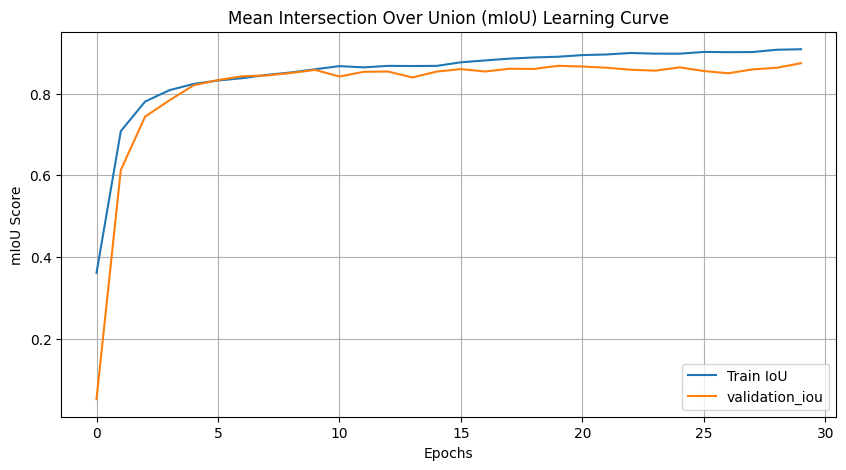

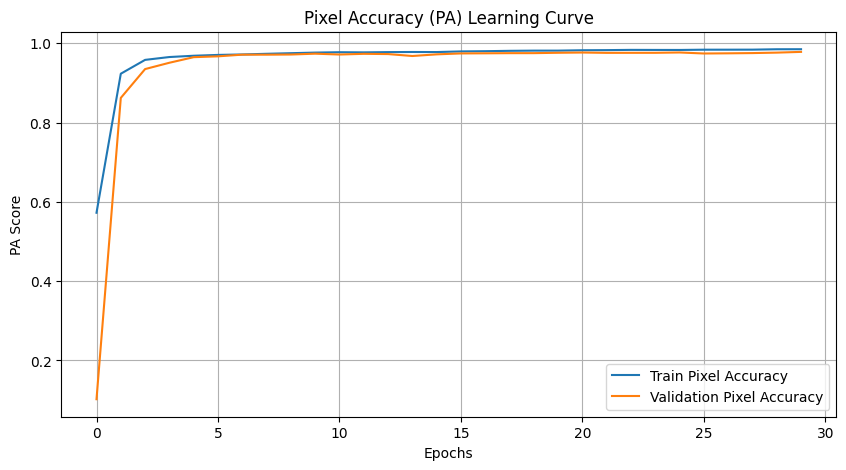

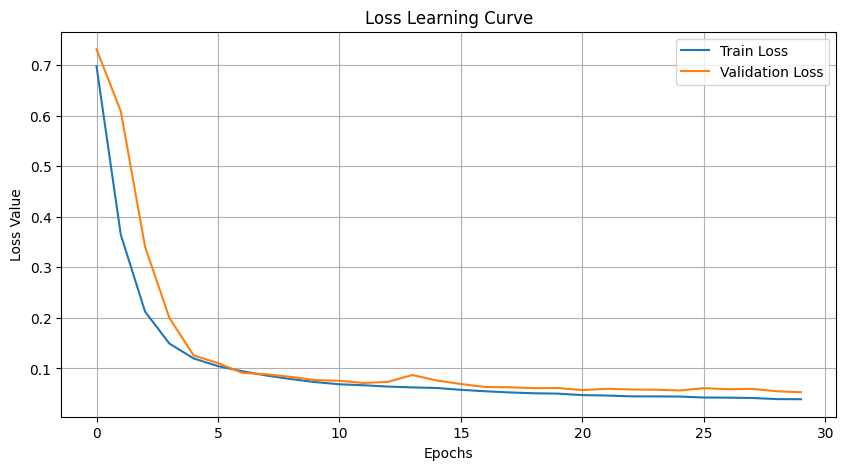

In [10]:
class Plot:
    def __init__(self, final):
    
        self.final = final
        self.plot_all()

    def plot_metric(self, metric1, metric2, label1, label2, title, ylabel):
     
        plt.figure(figsize=(10, 5))
        plt.plot(self.final[metric1], label=label1)
        plt.plot(self.final[metric2], label=label2)
        plt.title(title)
        plt.xlabel("Epochs")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_all(self):
    
        self.plot_metric(
            metric1="tr_iou", metric2="vl_iou",
            label1="Train IoU", label2="validation_iou",
            title="Mean Intersection Over Union (mIoU) Learning Curve",
            ylabel="mIoU Score"
        )
        self.plot_metric(
            metric1="tr_pa", metric2="vl_pa",
            label1="Train Pixel Accuracy", label2="Validation Pixel Accuracy",
            title="Pixel Accuracy (PA) Learning Curve",
            ylabel="PA Score"
        )
        self.plot_metric(
            metric1="tr_loss", metric2="vl_loss",
            label1="Train Loss", label2="Validation Loss",
            title="Loss Learning Curve",
            ylabel="Loss Value"
        )

Plot(final)

C:\Users\Nodir\AppData\Local\Temp\ipykernel_18788\1951134982.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(model_path, map_location=device)


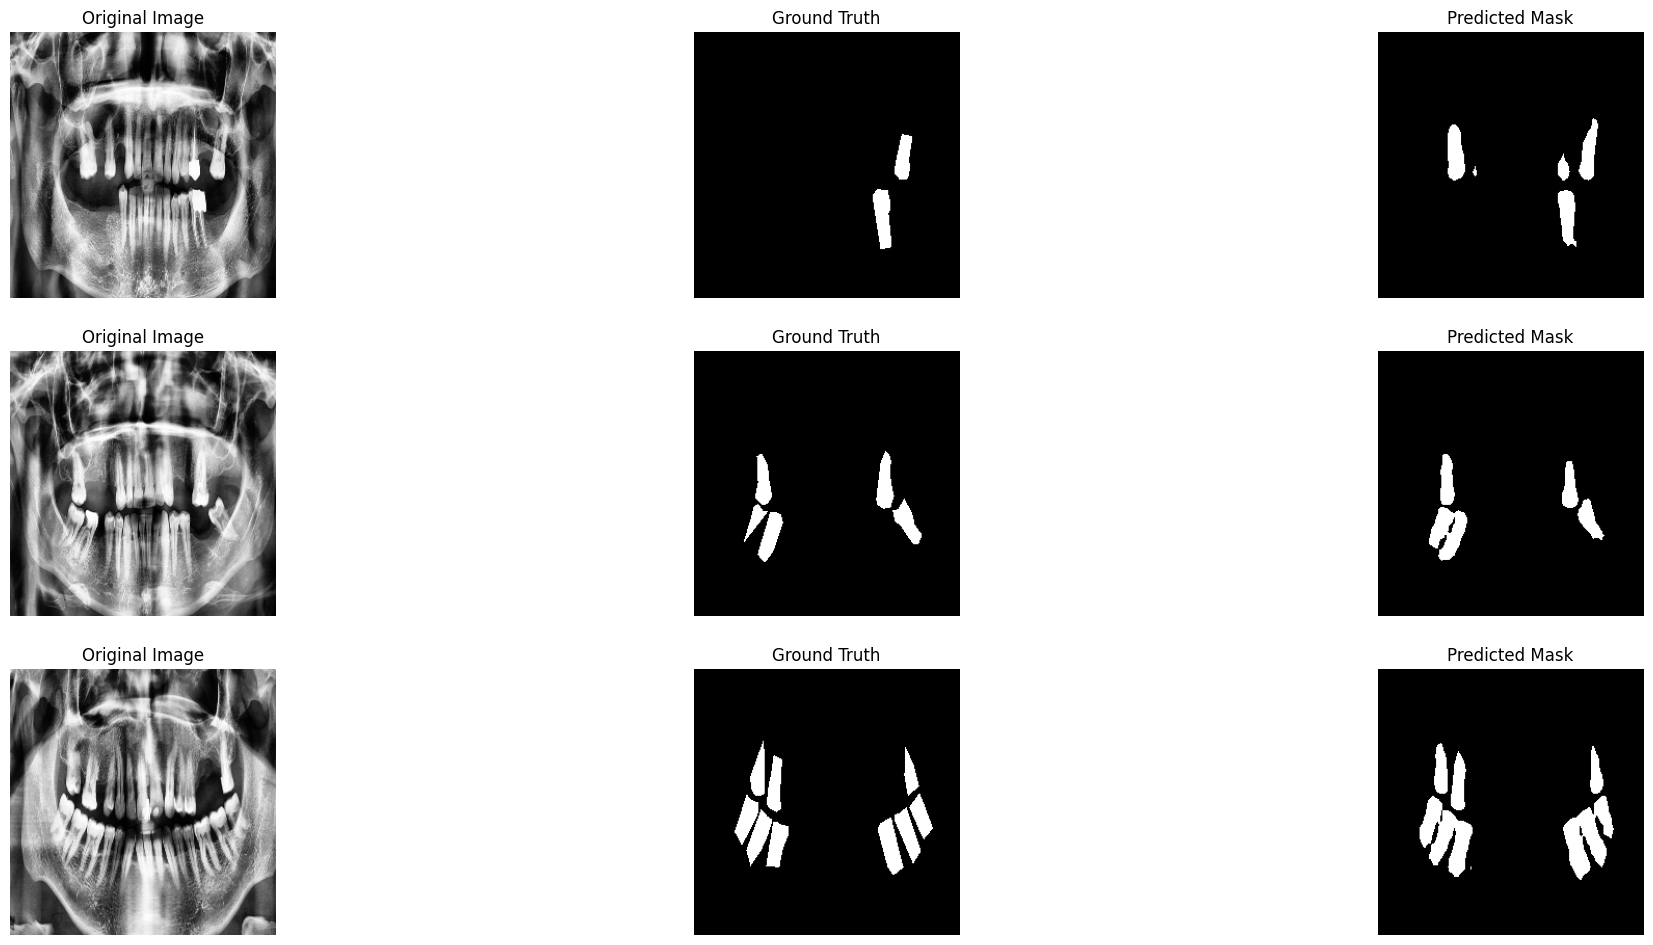

In [13]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as tfs
import numpy as np


class Inference:
    def __init__(self, model_path, device):

        self.device = device
        self.model = torch.load(model_path, map_location=device)
        self.model.to(device)
        self.model.eval()

    def tn_2_np(self, t):

        invTrans = tfs.Compose([
            tfs.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
            tfs.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
        ]) # inverse transformation (denormalization)
        rgb = True if len(t.shape) == 3 else False
        return (invTrans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8) if rgb else (t * 255).detach().cpu().numpy().astype(np.uint8)

    def plot(self, rows, cols, count, im, gt=None, title="Original Image"):
    
        plt.subplot(rows, cols, count)
        plt.imshow(self.tn_2_np(im.squeeze(0).float()), cmap = "gray") if gt else plt.imshow(self.tn_2_np(im.squeeze(0)), cmap = "gray")
        plt.axis("off")
        plt.title(title)
        return count + 1

    def run(self, dl, n_ims=15, cols = 3):

        rows = n_ims // cols
        count = 1
        ims, gts, preds = [], [], []

        # Perform inference
        for idx, data in enumerate(dl):
            im, gt = data

            with torch.no_grad():
                pred = torch.argmax(self.model(im.to(self.device)), dim=1) # (bs, chs, im_h, im_w) -> (bs, im_h, im_w) ->

            ims.append(im)
            gts.append(gt)
            preds.append(pred)

        # Visualize results
        plt.figure(figsize=(25, 20))
        for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
            if idx == cols:
                break

            # Plot original image
            count = self.plot(rows, cols, count, im)

            # Plot ground truth
            count = self.plot(rows, cols, count, im=gt.squeeze(0), gt=True, title="Ground Truth")

            # Plot predicted mask
            count = self.plot(rows, cols, count, im=pred, title="Predicted Mask")


model_path = "segmentation Best models/dentaldental_best_model.pth"
inference_runner = Inference(model_path=model_path, device=device)
inference_runner.run(ts_dl, n_ims=15)